# Gigi Giralté
## Assignment 13, 11/22/21

The purpose of this notebook is to combine my code for assignment 13, my forecast, with my markdown file that explains the code. By using a Jupyter notebook, these two are combined, allowing for easier reading and explanations. 

Thus far, I would believe that I have been doing well in the forecast competition as I'm currently tied for first place. At the beginning, I believe I was just lucky in guessing what the flow values would be but as we've learned more about coding and analyzing data, my forecasts have started to become more accurate. While I'm not 100% every single week, I have refined my forecast analysis process. I've been using the forecasted precipitation values from Wunderground for Camp Verde and have had accurate results from using those predictions. 

In [41]:
#Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import datetime
import seaborn as sns
import geopandas as gpd
import fiona
from shapely.geometry import Point
import contextily as ctx
import os
#import ggplot

In [42]:
# Camp Verde Stream Gage
url_1 = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=09506000&referred_module=sw&period=&begin_date=1990-01-01&end_date=2021-11-20"
data = pd.read_table(url_1, skiprows=30, names=['agency_cd', 'site_no',
                                               'datetime', 'flow', 'code'],
                                               parse_dates =['datetime'])

data['year'] = pd.DatetimeIndex(data['datetime']).year
data['month'] = pd.DatetimeIndex(data['datetime']).month
data['day'] = pd.DatetimeIndex(data['datetime']).day
data['dayofweek'] = pd.DatetimeIndex(data['datetime']).dayofweek

data_i = data.copy()
data_i = data_i.set_index('datetime')

### Graphs:
Below you can see two graphs that analyze the Camp Verde Stream Flow Data. The first graph shows the flow for this past week and the second graph shows the historical flow for the month of November. 

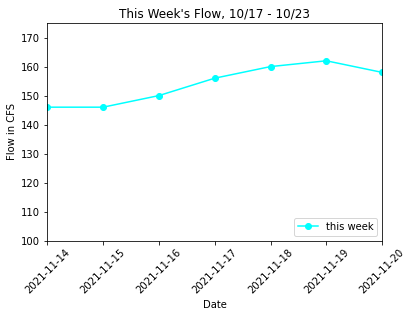

In [43]:
fig, ax = plt.subplots()
ax.plot(data_i.index.values, data_i['flow'], color='aqua', label='this week', marker = "o")
ax.set(title="This Week's Flow, 10/17 - 10/23", xlabel='Date', ylabel='Flow in CFS',
       xlim=[datetime.date(2021, 11, 14), datetime.date(2021, 11, 20)],
       ylim=[100, 175])
ax.legend(loc='lower right')
plt.setp(ax.get_xticklabels(), rotation=45)  # This rotates the x-axis labels so that they fit better on the plot
plt.show
fig.savefig("Nov11_20_Flow.png")

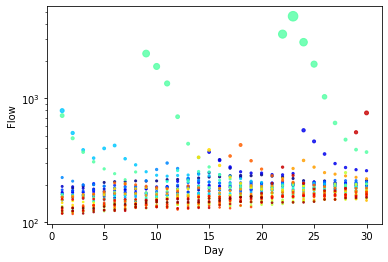

In [44]:
nov_data = data[data['month']==11]
fig, ax = plt.subplots()
ax.scatter(nov_data['day'], nov_data['flow'], alpha=0.8,
            s=0.02*nov_data['flow'], c=nov_data['year'], cmap='jet')
ax.set(yscale='log', xlabel = "Day", ylabel = "Flow")
plt.show()
fig.savefig("Historical_Nov_Flow.png")

### What I Added
I tried to add another plot using ggplot but I was getting an error above in the import statements that wouldn't allow it to import so I'm not really quite sure how to fix it. Thus, I'm not quite sure if the code below actually runs and is accurate. 

Nonetheless, I received this idea from the following link: https://nbviewer.org/gist/msund/7ac1203ded66fe8134cc

I liked being able to hover my mouse over the plot and have the value display, something from ggplot. 

In [ ]:
a = ggplot(aes(x='flow'), data=data) + geom_histogram() + ggtitle("Flow")
fig = a.draw()
py.iplot_mpl(fig)

### Map
I used the map that Sierra used in our Group Forecast from last week but I changed the color map and I added the watershed boundary that we are using. 

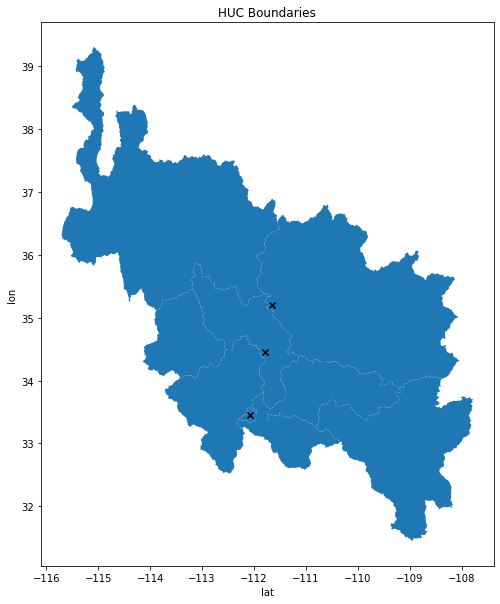

In [45]:
# Link: https://apps.nationalmap.gov/downloader/#/
# USGS National Hydrography Dataset Plus High Resolution (NHDPlus HR) for 4-digit Hydrologic Unit - 1506 (published 20180813)

# Open the files from my computer
file = os.path.join('../../data/NHDPLUS_H_1506_HU4_GDB', 'NHDPLUS_H_1506_HU4_GDB.gdb')
fiona.listlayers(file)
HUC6 = gpd.read_file(file, layer="WBDHU6") # Grab the layer we want

# Adding specific points to the map
# Phoenix coords: 33.4484, -112.0740
# Stream gauge:  34.44833333, -111.7891667
# Flagstaff coords: 35.1983, -111.6513

# First make a numpy array
coords = np.array([[-112.0740, 33.4484], [-111.7891667, 34.44833333], [-111.6513, 35.1983]])
point_geo = [Point(xy) for xy in coords]
point_df = gpd.GeoDataFrame(point_geo, columns=['geometry'],
                            crs=HUC6.crs) # Add into a dataframe

# New plot with the points added
fig, ax = plt.subplots(figsize=(10, 10))
HUC6.plot(ax=ax)
point_df.plot(ax=ax, color='black', marker='x')
ax.set_title("HUC Boundaries")
ax.set(xlabel = 'lat', ylabel = 'lon')
plt.show()

No handles with labels found to put in legend.


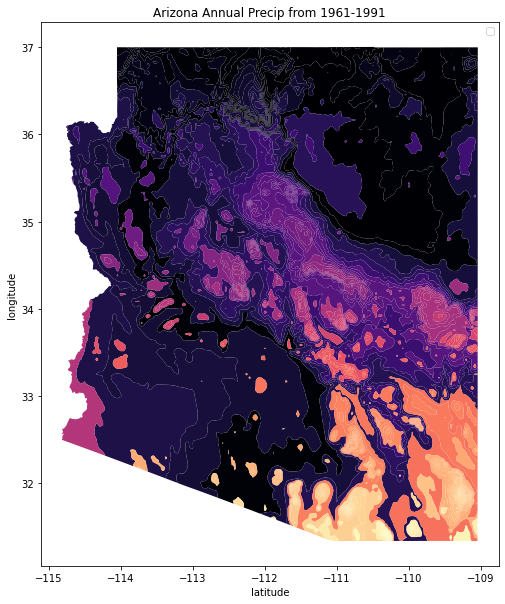

In [46]:
# Hopefully get annual precip data

file = os.path.join("../../data/Average_Annual_Precipitation_-_AZ_(1961_-_1990)-shp", 'Average_Annual_Precipitation_-_AZ_(1961_-_1990).shp')
annual_precip = gpd.read_file(file)

precip = annual_precip.to_crs(epsg=4269)
fig, ax = plt.subplots(figsize=(10, 10))
precip.plot(categorical=False, legend=True, markersize=45, cmap = 'magma', ax=ax, label = 'Precip Amounts')
ax.set(title="Arizona Annual Precip from 1961-1991",
       xlabel='latitude', ylabel='longitude')
ax.legend()
plt.show()

[Text(0.5, 1.0, 'Annual Precip of Arizona 1961 - 1991'),
 Text(0.5, 69.0, 'lat'),
 Text(121.71060791488708, 0.5, 'lon')]

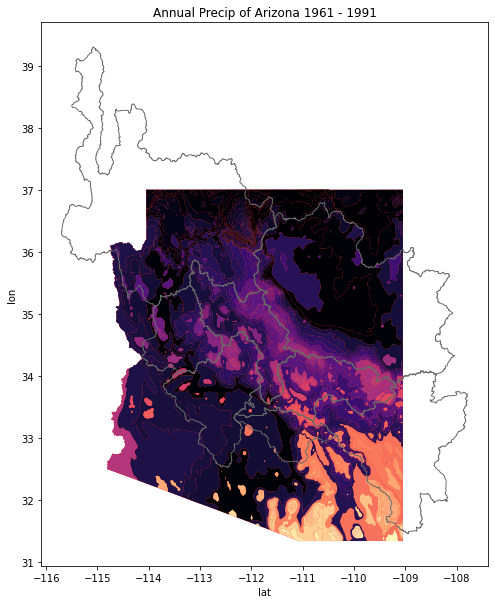

In [47]:
#Combine the plots
project = precip.to_crs(HUC6.crs)

fig, ax = plt.subplots(figsize = (10, 10))
HUC6.boundary.plot(ax=ax, color=None,
                           edgecolor='dimgray', linewidth=0.9, label="Watershed boundry")
project.plot(ax=ax, color = 'red', marker = 'x', label = "N to S: Flagstaff, \nOur Stream Gage, Phoenix")
precip.plot(categorical=False, legend=True, markersize=45, cmap = 'magma', ax=ax, label = 'Precip Amounts')
ax.set(title = 'Annual Precip of Arizona 1961 - 1991', xlabel = 'lat', ylabel = 'lon')

### Forecast
The way I generated my forecasts was using the function that I wrote in the past. This function finds the average flow for the past week, the minimum flow, and the maximum flow. From here, the difference between the max and min is found. To get the first week forecast, it's simply this past week's flow average. For the second week forecast, it's the forecast average minus the difference between the max and min flow values.

In [48]:
def forecasts(month1, month2, day_start, day_end):
        '''
        This function determines the week 1 and week 2 forecast predictions based on the forecasted precip in Camp Verde

        Parameters:
        "month1" represents the month of November (int)
        "month2" represents November (int)
        "day_start" represents this past Sunday, the 14th. (int)
        "day_end" represents Saturday, the 20th. (int)

        Outputs:
        This function returns a print statement that provides the forecasted flows for week 1 and week 2. 
        '''
        week_flow = data_i['flow'][('2021-' + str(month1) + '-' + str(day_start)):('2021-' + str(month2) + '-' + str(day_end))]
        forecast_mean = np.mean(week_flow)

        week_min = np.min(week_flow)
        week_max = np.max(week_flow)
        difference = week_max - week_min
        forecast_wk2 = week_max - difference
        prediction = print("The forecast for week 1 is:", forecast_mean, \
                "and the forecast for week 2 is:", forecast_wk2)
        return(prediction)

forecasts(11, 11, 14, 20)

The forecast for week 1 is: 154.0 and the forecast for week 2 is: 146.0
